## Visualize validation loss

In [1]:
import torch
import numpy as np
from collections import defaultdict
import os

import matplotlib.pylab as plt
%matplotlib inline

initialmodels_path = "/gpfs/gpfs0/y.gusak/pretrained/torchvision/models_torch_1-0-1"
initialstates_path = "/gpfs/gpfs0/y.gusak/pretrained/torchvision/state_dicts"

muscomodels_path = "/gpfs/gpfs0/y.gusak/musco_models"

import sys
sys.path.append('../')

from flopco import FlopCo

import sys
sys.path.append('/trinity/home/y.gusak/ReducedOrderNet/src')
from models.dcp.pruned_resnet import PrunedResNet

In [2]:
def get_prec(line):
    line = line.split('*')[-1].strip().split()
    prec1, prec5 = [float(el) for el in np.array(line)[[1, 3]]]
    
    return prec1, prec5


def get_beforeft_prec(logs):
    with open(logs, 'r') as f:
        lastline = f.readlines()[-1]
        
    prec1, prec5 = get_prec(lastline)
    return prec1, prec5


def get_val_prec(logs):
    with open(logs, 'r') as f:
        lines = [el.split('Test')[0].strip() for el in filter(lambda el : '*' in el, f.readlines())]
    
    prec1s = []
    prec5s = []

    for line in lines:
        prec1, prec5 = get_prec(line)

        prec1s.append(prec1)
        prec5s.append(prec5)
    
    return prec1s, prec5s


def get_all_prec(beforeft_logs, val_logs):

    prec1 = defaultdict(dict)
    prec5 = defaultdict(dict)

    prec1['beforeft'], prec5['beforeft'] =  get_beforeft_prec(beforeft_logs)
    prec1['val'], prec5['val'] = get_val_prec(val_logs)
    
    
    return prec1, prec5

In [3]:
def get_stats(model_names, grschedules, wfs, global_iters, local_iters):
    
    stats = defaultdict(dict)

    for model_name in model_names:
        for grschedule in grschedules:
            for wf in wfs:
                key1 = (model_name, grschedule, wf) 
                stats[key1] = defaultdict(dict)

                for global_iter in global_iters:
                    for local_iter in local_iters:
                        key2 = (global_iter, local_iter)
                        stats[key1][key2] = defaultdict(dict)
                        
                        load_path = '{}/{}/grschedule{}/tucker2_vbmf_wf{}/iter_{}-{}'.format(muscomodels_path,
                                                                     model_name,
                                                                     grschedule,
                                                                     wf, global_iter, local_iter)

                        beforeft_logs = '{}/ftlogs/beforeft_logs.log'.format(load_path)
                        val_logs = '{}/ftlogs/val_logs.log'.format(load_path)
                        train_logs = '{}/ftlogs/train_logs.log'.format(load_path)

                        
                        if os.path.isfile(val_logs):
                            stats[key1][key2]['prec1'], stats[key1][key2]['prec5'] = get_all_prec(beforeft_logs,
                                                                                              val_logs)

                            m = torch.load('{}/beforeft.pth'.format(load_path))
                            flopco_m = FlopCo(m)
                            stats[key1][key2]['flops'] = flopco_m.total_flops
                            
                            stats[key1][key2]['params'] = count_params(m)
                            
                            del m
                            torch.cuda.empty_cache()

        
    return stats


def get_baseline_flops_params(model_names, initialmodels_path):
    flops = defaultdict()
    params = defaultdict()
    
    
    for model_name in model_names:
        m = torch.load('{}/{}.pth'.format(initialmodels_path, model_name))
        
        flopco_m = FlopCo(m)
        flops[model_name] = flopco_m.total_flops
        params[model_name] = count_params(m)
        
    return flops, params


def count_params(model):
    params = 0
    for p in model.parameters():
        params += p.numel()
        
    return params

In [4]:
model_names = ['resnet18_imagenet', 'resnet50_imagenet',
               'resnet50_pruned0.3', 'resnet50_pruned0.5', 'resnet50_pruned0.7']

stats = []
stats.append(get_stats(model_names, grschedules=[0], global_iters=[0, 1], local_iters=[0, 1, 2, 3],\
                   wfs=['0.5','0.6', '0.8', '0.9', '1.']))
stats.append(get_stats(model_names, grschedules=[1], global_iters=[0, 1], local_iters=[0, 1, 2, 3, 4, 5, 6, 7],
                   wfs=['0.6', '0.8', '1.']))

In [5]:
baselines_flops, baselines_params = get_baseline_flops_params(model_names[:2], initialmodels_path)
baselines_flops, baselines_params

(defaultdict(None,
             {'resnet18_imagenet': 3642221568,
              'resnet50_imagenet': 8234341888}),
 defaultdict(None,
             {'resnet18_imagenet': 11689512, 'resnet50_imagenet': 25557032}))

In [6]:
baselines = {'resnet18_imagenet':  ( 69.76, 89.0),
             'resnet50_imagenet': ( 76.15, 92.87)}

baselines_sota = {'resnet18_imagenet': [(-2.54, -1.46, 1.98), (-2.29, -1.38, 1.89), (-1.62, -1.03, 1.61)],
                  'resnet50_imagenet': [(-1.06, -0.61, 2.25), (-1.87, -1.12, 2.25), (-1.54, -0.81, -1.54)]}

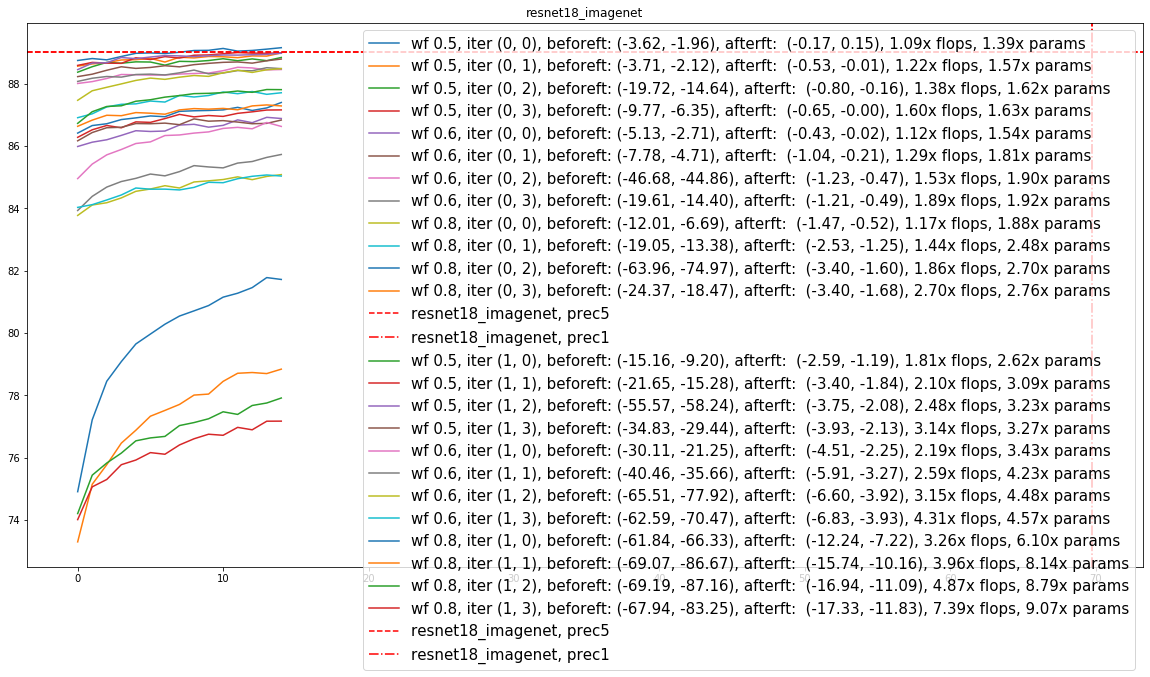

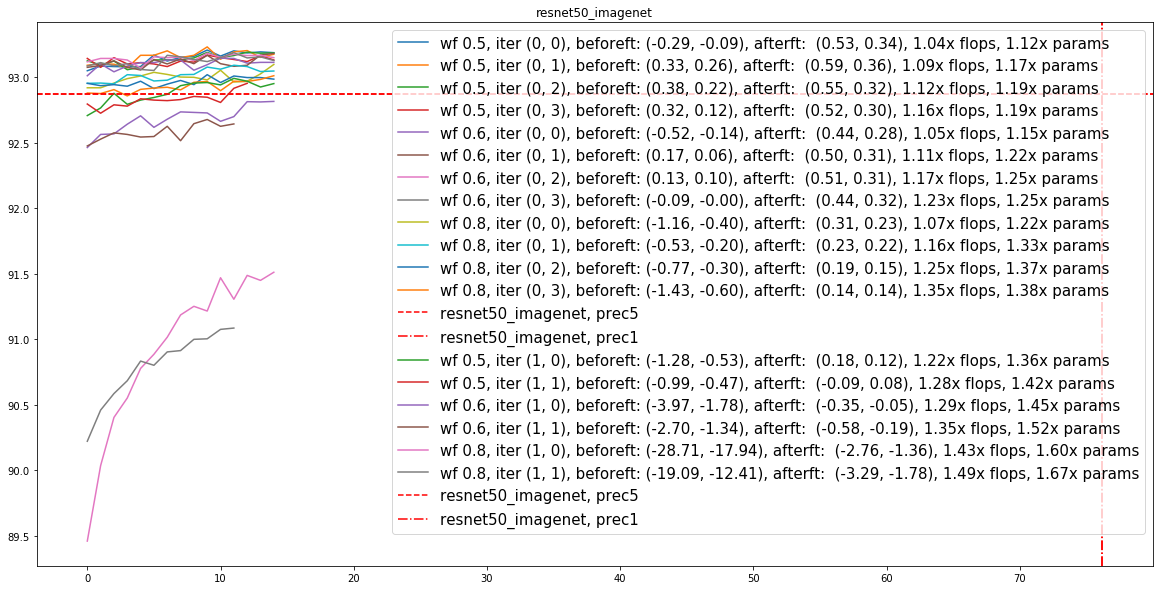

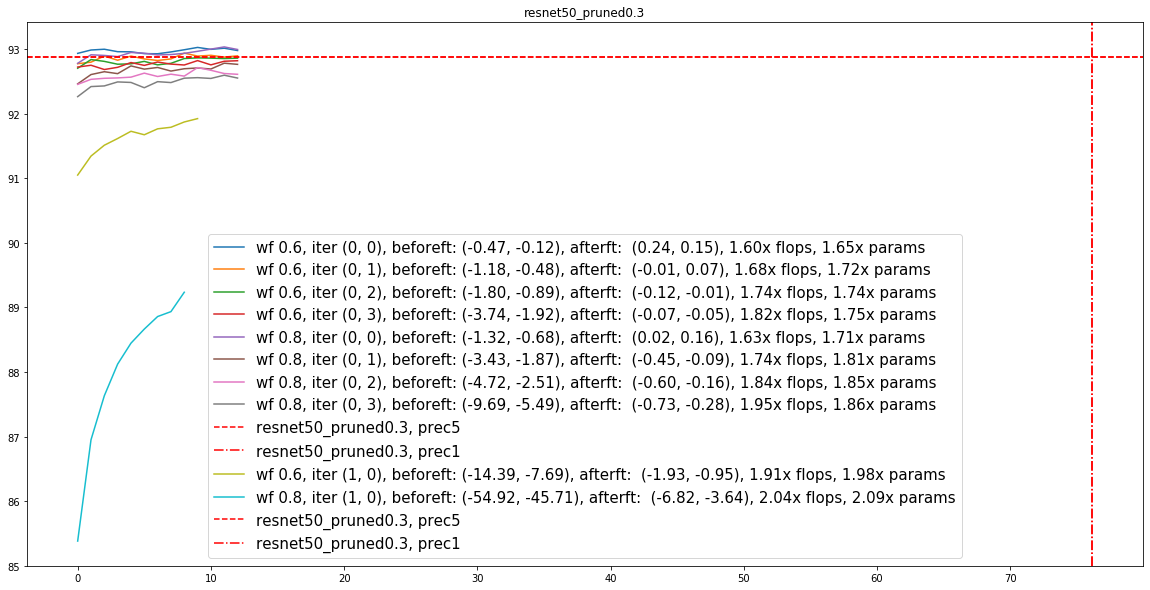

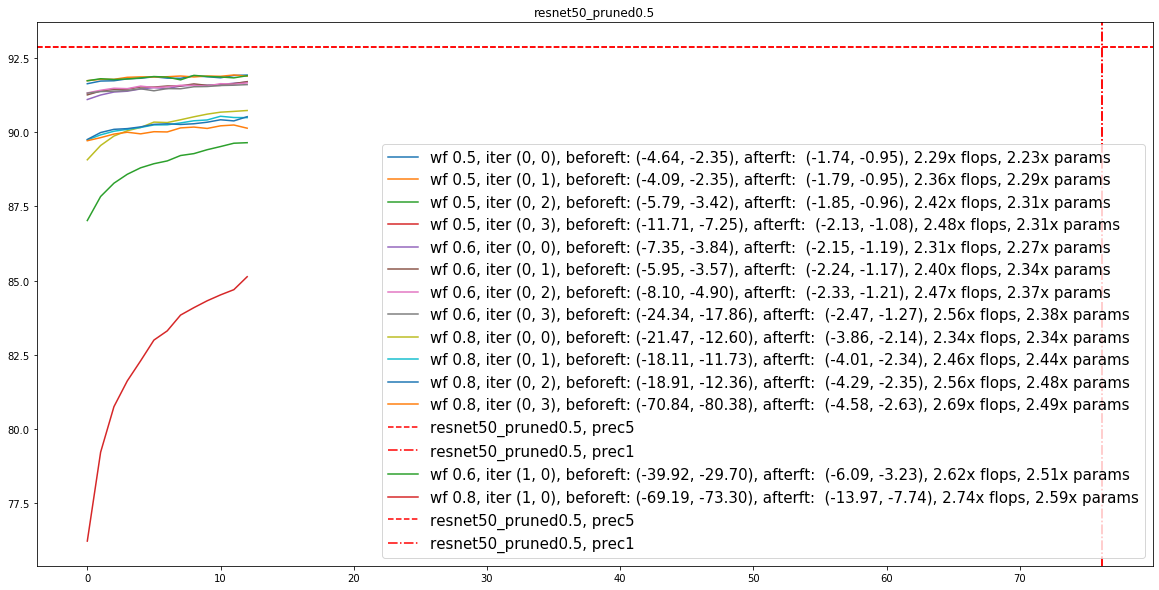

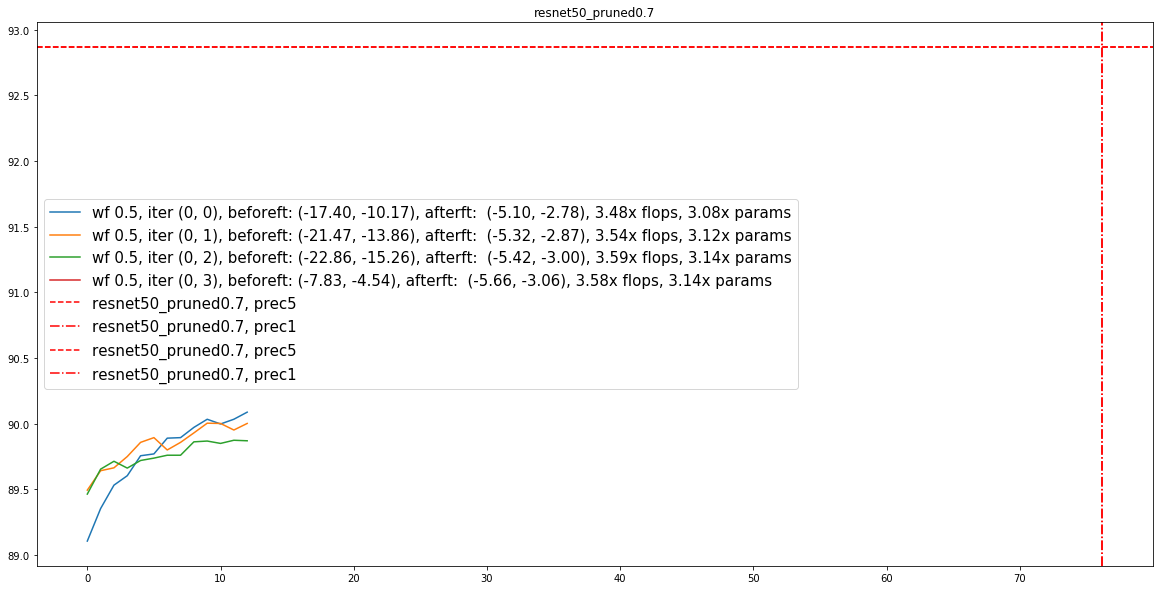

In [7]:
grschedule = 0


stat = stats[grschedule]

for model_name in model_names:
    baseline_name = 'resnet50_imagenet' if '50' in model_name else 'resnet18_imagenet'
    
    b1 = baselines[baseline_name][0]
    b5 = baselines[baseline_name][1]
    

    plt.figure(figsize = (20, 10))
    for global_iter in [0,1]:

        for wf in ['0.5', '0.6', '0.8', '0.9' '1.'][:]:

            for local_iter in [0, 1, 2, 3, 4, 6, 7][:]:
                name = (model_name, grschedule, wf)
                iterr = (global_iter, local_iter)

                try:
                    prec1s = stat[name][iterr]['prec1']
                    prec5s = stat[name][iterr]['prec5']
                    flops = stat[name][iterr]['flops']
                    params = stat[name][iterr]['params']
                    


#                     plt.plot(prec1s['val'], prec5s['val'],
#                              label = 'wf {}, iter {}, beforeft: {}, afterft: {}, {:.2f}x flops, {:.2f}x params'.format(wf,
#                                                                                     iterr,
#                                                                                     (prec1s['beforeft'],
#                                                                                      prec5s['beforeft']),
#                                                                                     (max(prec1s['val']),
#                                                                                      max(prec5s['val'])),                                   
#                                                                                     baselines_flops[baseline_name]/flops,
#                                                                                     baselines_params[baseline_name]/params))

    

                    plt.plot(prec5s['val'], 
                         label = 'wf {}, iter {}, beforeft: ({:.2f}, {:.2f}), afterft:  ({:.2f}, {:.2f}), {:.2f}x flops, {:.2f}x params'.format(wf,
                                                                                iterr,
                                                                                prec1s['beforeft']-b1,
                                                                                 prec5s['beforeft']-b5,
                                                                                max(prec1s['val'])-b1,
                                                                                 max(prec5s['val'])-b5,                                   
                                                                                baselines_flops[baseline_name]/flops,
                                                                                baselines_params[baseline_name]/params))

                except:
                    continue



        plt.axhline(y=baselines[baseline_name][1], color='r', linestyle='--',
                    label = '{}, prec5'.format(model_name))  
        plt.axvline(x=baselines[baseline_name][0], color='r', linestyle='-.',
                label = '{}, prec1'.format(model_name))

    #     plt.axhline(y=baselines_sota[model_name][1][1], color='b', linestyle='--',
    #             label = 'sota{}, prec5'.format(1))


        plt.title('{}'.format(model_name))
        plt.legend(fontsize = 15)

defaultdict(dict,
            {('resnet18_imagenet', 0, '0.5'): defaultdict(dict,
                         {(0, 0): defaultdict(dict,
                                      {'prec1': defaultdict(dict,
                                                   {'beforeft': 66.142,
                                                    'val': [68.864,
                                                     69.158,
                                                     69.062,
                                                     69.292,
                                                     69.28,
                                                     69.182,
                                                     69.468,
                                                     69.278,
                                                     69.32,
                                                     69.49,
                                                     69.414,
                                                     